# problem

\begin{align}
  I = \int_a^1 c\cdot x^{-k-1}(1-x)^{k+1}dx.
\end{align}
Assume $a = 10^{-5}$, $c=10^{-9}$, and $k=2$.


# import module and basic setup

In [1]:
using StatsPlots, HaltonSequences, Random, QuadGK, Distributions, StaticArrays


g(x; c=1e-9, k=2) = c * x^(-k-1) * (1-x)^(k+1)

x_MCM(a, b, t) = a + (b-a)*t
f_MCM(t, a=1e-5, b=1) = g(x_MCM(a, b, t)) * (b-a)

trueVal = quadgk(g, 1e-5, 1)[1]
# n = 19, 20, 21, 23, 26
NodesNum = @SVector [524_287, 1_048_575, 2_097_151, 8_388_607, 67_108_863];

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1423

(process:20816): GLib-GIO-WARNING **: 13:50:41.860: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.3.2.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 46 extensions but has no verbs

(process:16984): GLib-GIO-WARNING **: 13:51:15.809: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.3.2.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 46 extensions but has no verbs


### <span style="color:#ebcb8b">issue: static array</span>

# MCM and Quasi MCM

### <span style="color:#5e81ac">review: monte carlo integration</span>
$$\begin{aligned}
\int_a^b g(x) dx = \int_0^1 f(t)dt  = E[f(t)] \approx  \bar{f}_n =  \frac{1}{n} \sum_{i=1}^n f(t_i),
\end{aligned}$$

In [2]:
function MCM(NodesNum::SVector, trueVal::Float64; prec::Int64=2, seed::Int64=9139)
    n = length(NodesNum)
    MCM_deviate = zeros(SizedVector{n})
    compVal = round(trueVal, RoundDown, digits=prec)
    converge = -1
    for i in 1:n
        res = mean(f_MCM.(rand(Xoshiro(seed), NodesNum[i])))
        MCM_deviate[i] = abs(res-trueVal)
        if converge == -1 && round(res, RoundDown, digits=prec) == compVal
            converge = NodesNum[i]
        end
    end
    return MCM_deviate, converge
end

MCM (generic function with 1 method)

### <span style="color:#ebcb8b">issue: seed selection</span>
```julia
res[j] = mean(f_IS.(rand(d, NodesNum[j])))
deviate[i] = abs(mean(res)-trueVal)
return seed = Seed[argmin(deviate)]
```

In [3]:
function quaMCM(NodesNum::SVector, trueVal::Float64; prec::Int64=2, prime::Int64=2)
    n = length(NodesNum)
    compVal = round(trueVal, RoundDown, digits=prec)
    quaMCM_deviate = zeros(SizedVector{n})
    converge = -1
    for i in 1:n
        res = mean(f_MCM.(Halton(prime, length=NodesNum[i])))
        quaMCM_deviate[i] = abs(res-trueVal)
        if converge == -1 && round(res, RoundDown, digits=prec) == compVal
            converge = NodesNum[i]
        end
    end
    return quaMCM_deviate, converge
end

quaMCM (generic function with 1 method)

# importance sampling
- picked distribution: truncated normal

### <span style="color:#5e81ac">review: truncated normal</span>
- the truncated normal can specify the bound and the parameter is the original normal's $\mu$, $\sigma^2$ and the lower and upper bound: [a,b]
- denote f(x), F(x) to be the original normal distribution's pdf and cdf
- $\phi(z), \Phi(z)$ is the pdf and cdf of the standard normal distribution 
- pdf of truncated normal
    - $\frac{f(x)}{F(b)-F(a)} = \frac{\phi(\frac{x-\mu}{\sigma})}{\sigma(\Phi(\beta)-\Phi(\alpha))}$
    - $\alpha = \frac{a-\mu}{\sigma}$, $\beta = \frac{b-\mu}{\sigma}$
    - $F(b)-F(a) = \Phi(\beta)-\Phi(\alpha)$ is the area of the bound we specify
        - the purpose to divide it is to make sure the integration of the pdf equals to 1
        - as for the HWK4 example, $\beta=\infty$, $\alpha=0$, $\Phi(\beta)-\Phi(\alpha)=1-\Phi(-\frac{\mu}{\sigma})=1-(1-\Phi(\frac{\mu}{\sigma}))=\Phi(\frac{\mu}{\sigma})$
    - $\frac{1}{\sigma}$ is the jacobian, note: $f(x) = \frac{\phi(x)}{\sigma}$
- cdf of truncated normal
    - $\int_a^x \frac{\phi(\frac{y-\mu}{\sigma})}{\sigma(\Phi(\beta)-\Phi(\alpha))} = \frac{\sigma(\Phi(\frac{x-\mu}{\sigma})|_a^x)}{\sigma(\Phi(\beta)-\Phi(\alpha))} = \frac{\Phi(\frac{x-\mu}{\sigma})-\Phi(\alpha)}{\Phi(\beta)-\Phi(\alpha)}$
- quantile of truncated normal
    - inverse function of the cdf of the truncated normal

### note:
- the new expectation
    - $E(X) = \int_a^b x\frac{\phi(\frac{x-\mu}{\sigma})}{\sigma(\Phi(\beta)-\Phi(\alpha))} = \frac{-\sigma^2\int_a^bf(x)\frac{x-\mu}{-\sigma^2}dx+\mu\int_a^bf(x)dx}{\Phi(\beta)-\Phi(\alpha)} = \frac{-\sigma^2\int_a^bf'(x)dx+\mu F(x)|_a^b}{\Phi(\beta)-\Phi(\alpha)} = \mu + \frac{-\sigma^2f(x)|_a^b}{\Phi(\beta)-\Phi(\alpha)} = \mu + \sigma\frac{\phi(\alpha)-\phi(\beta)}{\Phi(\beta)-\Phi(\alpha)}$
- the new variance
    - $Var(X) = E(X^2)-E(X) = \sigma^2(1+\frac{\alpha\phi(\alpha)-\beta\phi(\beta))}{\Phi(\beta)-\Phi(\alpha)}-(\frac{\phi(\alpha)-\phi(\beta))}{\Phi(\beta)-\Phi(\alpha)})^2)$

In [4]:
function IS_random(d, NodesNum::SVector, trueVal::Float64; prec::Int64=2, seed::Int64=18708)
    n = length(NodesNum)
    compVal = round(trueVal, RoundDown, digits=prec)
    IS_deviate = zeros(SizedVector{n})
    converge = -1
    f_IS(x) = f_MCM(x) / pdf(d, x)
    Random.seed!(seed)
    for i in 1:n
        res = mean(f_IS.(rand(d, NodesNum[i])))
        IS_deviate[i] = abs(res-trueVal)
        if converge == -1 && round(res, RoundDown, digits=prec) == compVal
            converge = NodesNum[i]
        end
    end
    return IS_deviate, converge
end

IS_random (generic function with 1 method)

### <span style="color:#5e81ac">review: inverse transform sampling </span>
- chinese: 逆萬流歸宗
- probability inverse integral(PIT):
    - let $X$ be a continuous random variable that has a CDF $F_X(x)$ which is also continuous
    - Because $X$ is a random variable, $F_X(X)$ is also random
    - If we define a random variable $Y$ as $Y=F_X(X)$, then $Y \sim U(0,1)$.
- method 
    - $Y\sim U(0,1)$, we draw values $y$ from $U(0,1)$, pass them through $F^{-1}(y)$ and get $x$ which would has the distribution of $F(x)$.


In [5]:
function IS_halton(d, NodesNum::SVector, trueVal::Float64; prec::Int64=2)
    n = length(NodesNum)
    compVal = round(trueVal, RoundDown, digits=prec)
    IS_deviate = zeros(SizedVector{n})
    converge = -1
    f_IS(x) = f_MCM(x) / pdf(d, x)
    for i in 1:n
        sample = quantile.(d, Halton(2, length=NodesNum[i]))
        res = mean(f_IS.(sample))
        IS_deviate[i] = abs(res-trueVal)
        if converge == -1 && round(res, RoundDown, digits=prec) == compVal
            converge = NodesNum[i]
        end
    end
    return IS_deviate, converge
end

IS_halton (generic function with 1 method)

# present the result

In [6]:
MCM_deviate, MCM_converge = MCM(NodesNum, trueVal)
quaMCM_deviate, quaMCM_converge = quaMCM(NodesNum, trueVal)

([0.8637475722937928, 0.454145603219275, 0.23272695316879322, 0.059246431345927775, 0.007444657298796287], 67108863)

In [21]:
d = truncated(Normal(1e-3, 1e-3), 0, 1)
ISr_deviate, ISr_converge = IS_random(d, NodesNum, trueVal)
ISh_deviate, ISh_converge = IS_halton(d, NodesNum, trueVal, prec=3)
@show MCM_converge, quaMCM_converge, ISr_converge, ISh_converge

(MCM_converge, quaMCM_converge, ISr_converge, ISh_converge) = (-1, 67108863, -1, -1)


(-1, 67108863, -1, -1)

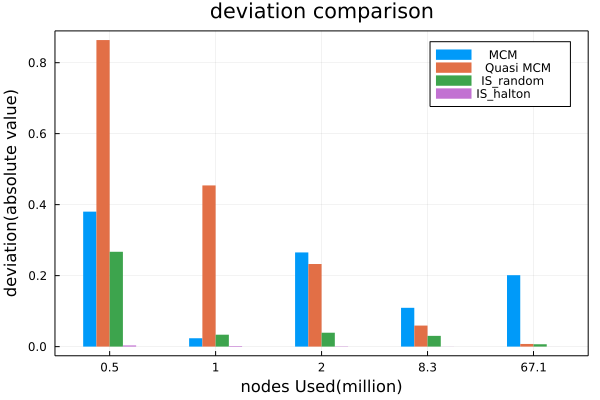

In [8]:
deviateMatrix = [MCM_deviate quaMCM_deviate ISr_deviate ISh_deviate]
x = ["    0.5    ", "   1   ", "  2  ", " 8.3 ", "67.1"]
x = repeat(x, outer=5)
label = ["   MCM   ", "  Quasi MCM  ", " IS_random ", "IS_halton"]
label = repeat(label, inner=5)
groupedbar(x, deviateMatrix, group=label, xlabel="nodes Used(million)",
            ylabel="deviation(absolute value)", title="deviation comparison",
            bar_width=0.5, lw=0, framestyle=:box)

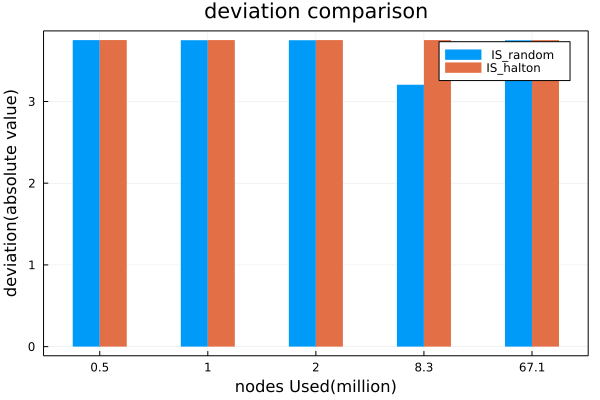

In [20]:
deviateMatrix = [ISr_deviate ISh_deviate]
x = ["    0.5    ", "   1   ", "  2  ", " 8.3 ", "67.1"]
x = repeat(x, outer=2)
label = [" IS_random ", "IS_halton"]
label = repeat(label, inner=5)
groupedbar(x, deviateMatrix, group=label, xlabel="nodes Used(million)",
            ylabel="deviation(absolute value)", title="deviation comparison",
            bar_width=0.5, lw=0, framestyle=:box)

# conclusion
- importance sampling can converge faster but the performance is limited

### <span style="color:#ebcb8b">exponential distribution</span>

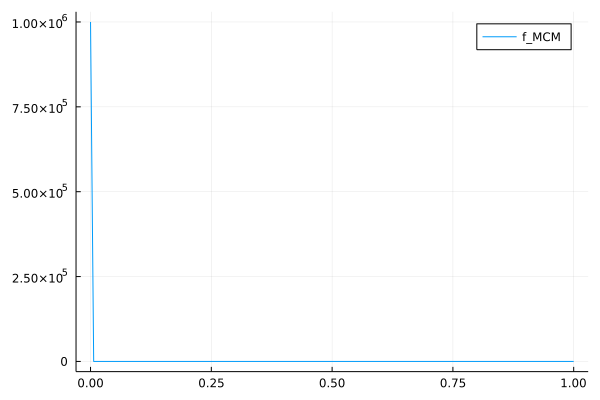

In [8]:
plot(f_MCM, xlim=[0, 1], label="f_MCM")

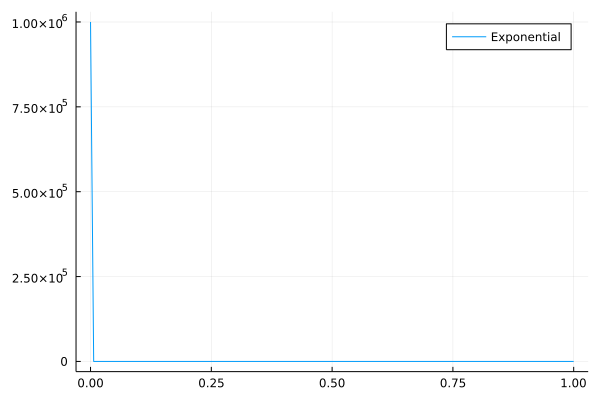

In [10]:
pdfE(x) = pdf(Exponential(1e-6), x)
plot(pdfE, xlim=[0, 1], label="Exponential")

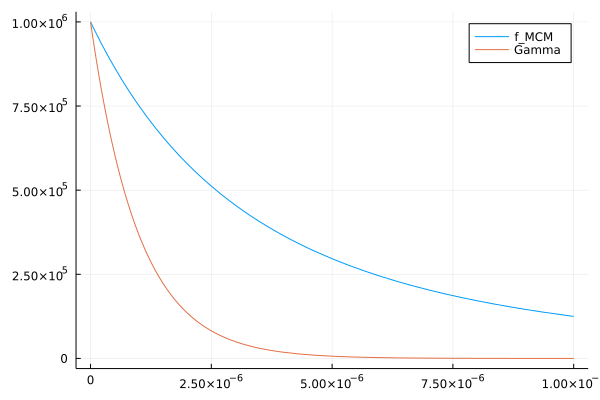

In [11]:
plot(f_MCM, label="f_MCM", xlim=[0, 1e-5])
plot!(pdfE, label="Exponential", xlim=[0, 1e-5])

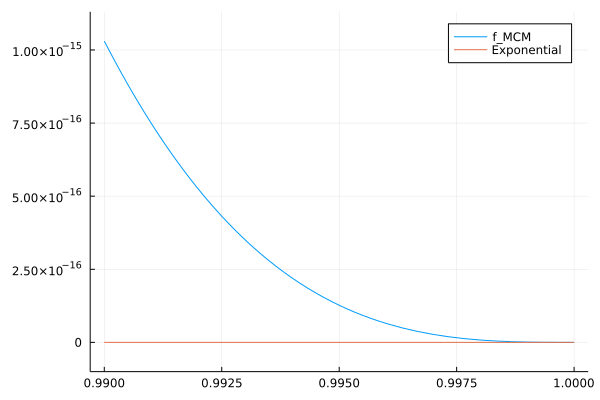

In [13]:
plot(f_MCM, label="f_MCM", xlim=[0.99, 1])
plot!(pdfE, label="Exponential", xlim=[0.99, 1])

In [17]:
d1 = truncated(Normal(1e-3, 1e-3), 0, 1)
d2 = truncated(Exponential(1e-6), 0, 1) 
ISh_normDeviate, converge_norm = IS_halton(d1, NodesNum, trueVal)
ISh_expEDeviate, converge_exp = IS_halton(d2, NodesNum, trueVal)
@show converge_norm, converge_exp

(converge_norm, converge_exp) = (524287, -1)


(524287, -1)

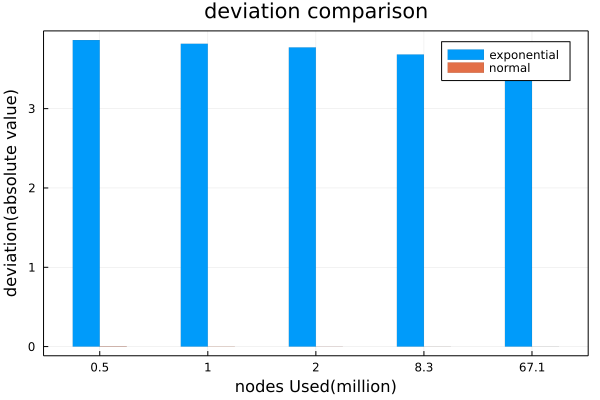

In [16]:
deviateMatrix = [ISh_normDeviate ISh_expEDeviate]
x = ["    0.5    ", "   1   ", "  2  ", " 8.3 ", "67.1"]
x = repeat(x, outer=2)
label = ["normal", "exponential"]
label = repeat(label, inner=5)
groupedbar(x, deviateMatrix, group=label, xlabel="nodes Used(million)",
            ylabel="deviation(absolute value)", title="deviation comparison",
            bar_width=0.5, lw=0, framestyle=:box)

# reference
- wiki
    - [truncated normal](https://en.wikipedia.org/wiki/Truncated_normal_distribution)
    - [inverse transform sampling](https://zh.wikipedia.org/zh-tw/%E9%80%86%E5%8F%98%E6%8D%A2%E9%87%87%E6%A0%B7)
- julia documentation
    - [truncated normal](https://juliastats.org/Distributions.jl/stable/truncate/)
    - [static array](https://juliaarrays.github.io/StaticArrays.jl/stable/)
- julia discussion
    - [difference between regular array and static array](https://discourse.julialang.org/t/whats-the-difference-between-a-regular-array-and-an-array-from-staticarrays/14454)
- github
    - [my source code](https://github.com/opottghjk00/numeric_method_julia/blob/main/05_MCM_importance_sampling/hw/converge_competition.jl)